# Plots for research paper

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#| code-fold: false
# IMPORTING LIBRARIES
# --------------------

# AstroML
from astroML.datasets import fetch_LINEAR_sample
from astropy.coordinates import SkyCoord
import astropy.units as u

# Basic libraries
import pickle
import os
import sys
from tqdm import tqdm

# Plotting
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import ticker
import matplotlib.colors as mcolors
from matplotlib.font_manager import FontProperties

# DataFrame analysis
import pandas as pd

# Math libraries
import numpy as np
import scipy as sc
from scipy.stats import norm

# CONFIGURATION
# -------------
sns.set_theme(style='white') # setting the theme for plotting
sys.path.insert(0,'../src/')
np.random.seed(42)

# configuring plotting colors
colors = ['#465BBB', '#A82F43', '#3F8FCE', '#7ABBCE', '#3A3865', '#612A37', '#DC5433', '#F29457']
b1 = '#465BBB'
b2 = '#3F8FCE'
b3 = '#7ABBCE'
b4 = '#3A3865'
black1 = '#22212A'
black2 = '#2D1E21'
or1 = '#A82F43'
or2 = '#612A37'
or3 = '#DC5433'
or4 = '#F29457'
muted_colors = sns.set_palette(sns.color_palette(colors))

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{txfonts}'  # Use TX Times font

# Set up your font properties (optional)
font = FontProperties()
font.set_family('serif')
font.set_name('Times')  # Times font
%matplotlib inline 

In [4]:
#| code-fold: false
# Importing custom libraries
# ----------------------------
sys.path.insert(0,'../src/')
from BE_plotting import*
#from RR_lyrae_params import*
from blazhko_analysis import*

In [5]:
#| code-fold: false
# DATA
dataL = fetch_LINEAR_sample(data_home='../inputs') # fetching the data from astroML data library
end = 'ffinal'

# DATA from previous notebook
BE_STARS = pd.read_csv('../outputs/FINAL_BE_CATALOGUE_EXPANDED.csv')
lc_master = pd.read_csv('../outputs/lc_MASTER.csv')
be_cand = pd.read_csv('../outputs/blazhko_candidates_expanded.csv')
lc_analysis = pd.read_csv("../outputs/LC_ANALYSIS_"+end+".csv")
rrlyrae = pd.read_csv('../outputs/Lrrlyr_unprocessed.csv')
periodogr = pickle.load(open("../outputs/periodograms_"+end+".pkl", "rb"))
fits = np.load("../outputs/fits_"+end+".npy", allow_pickle=True)
ztf_data = np.load("../outputs/ztf_data_filter"+end+".npy", allow_pickle=True)

## Model periodogram vs. real periodogram

In [5]:
import random
# SIMULATING LIGHT CURVE
Ngrid = 10000
Tmax = 100

fmain = 1.54
fbl = 1.57

Time = np.linspace(0, Tmax, Ngrid)
lcmain = np.sin(2*3.1415926*Time*fmain)
lc = 2*np.cos(2*3.1415926*Time*(fbl - fmain))*lcmain
lc = lc/np.max(lc)

In [7]:
#| code-fold: false
# SIMULATING OBSERVATION DATA

Ndata = 400
magErr = 0.1
Ablazhko = 0.5
time_data = Tmax * np.random.random(Ndata)

lcdata = np.sin(2*3.1415926*time_data*fmain) + Ablazhko*np.sin(2*3.1415926*time_data*fbl) + Ablazhko*np.sin(2*3.1415926*time_data*(2*fmain-fbl))
lcdata = lcdata/np.max(lcdata)
magErrObs = magErr + 0*time_data
LCbObsErr = lcdata + np.random.normal(0, magErrObs)

In [8]:
def doPeriods(time, mag, magErr, nterms, lsPS=True, nyquist=100, freqFac=1.05, verbose=True):
    try:
        if verbose:print('Starting calculations...')
        ls = LombScargle(time, mag, magErr, nterms=nterms) # set up a LombScargle object to model the frequency and power
        frequency = np.arange(1.0, 2.0, 5e-5)
        if verbose: print('Arranging frequencies to calculate...')
        power = ls.power(frequency)  # compute LS periodogram again
        period = 1. / frequency
        if verbose: print('Possible periods determined')
        # hack: limit around known frequency to avoid aliases
        powerRestricted = power[(frequency>1.3)&(frequency>1.7)]
        best_period = period[np.argmax(powerRestricted)] # choosing the period with the highest power
        if verbose: print("Best period is ", best_period)
        if lsPS: 
            return best_period, frequency, power
        else:
            return best_period
    except:
        return 'Error in doPeriods'

In [9]:
#| code-fold: false
period, freq, power = doPeriods(time_data, LCbObsErr, magErrObs, nterms=3)

Starting calculations...
Arranging frequencies to calculate...
Possible periods determined
Best period is  0.8175612148956506


In [11]:
# Choosing a good star
# ------------------------
star3 = [3507643]
order = list(BE_STARS['LINEAR id']).index(3507643)
for o, k in enumerate(periodogr):
    if k[0]==star3:
        break

fL = periodogr[o][1][0]
pL = periodogr[o][1][1]

fFoldedL = periodogr[o][1][2]
pFoldedL = periodogr[o][1][3]

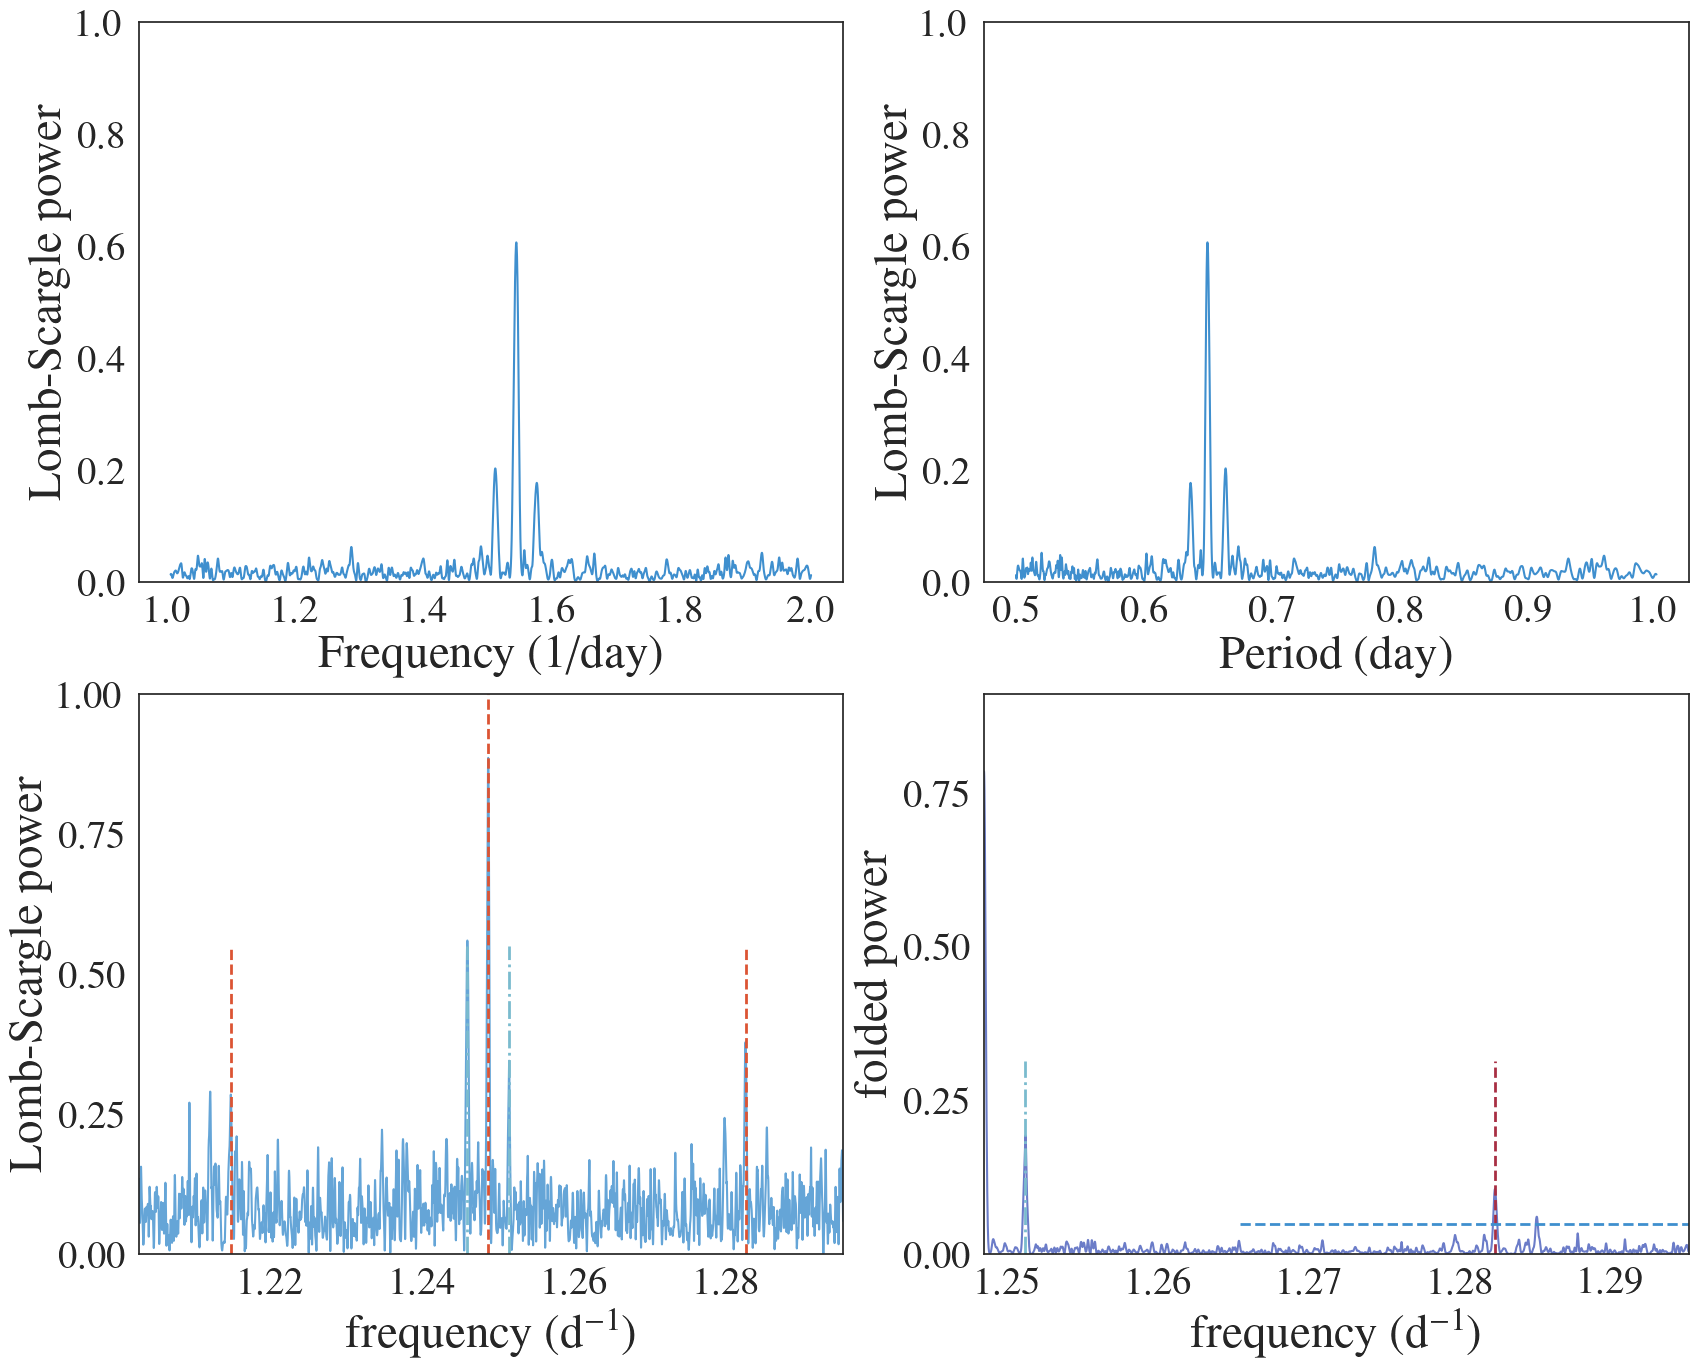

In [13]:
#| code-fold: false
# PLOTTING PERIODOGRAM:
fig = plt.figure(figsize=(20, 16))
fac=1.008

ax = fig.add_subplot(221)
ax.plot(freq, power, c=b2)
ax.set_ylim(0.0,1)
ax.set_ylabel('Lomb-Scargle power', fontproperties=font,fontsize=34)
ax.set_xlabel('Frequency (1/day)', fontproperties=font,fontsize=34)
ax.tick_params(labelsize=28)

ax = fig.add_subplot(222)
ax.plot(1/freq, power, c=b2)
ax.set_ylim(0.0,1)
ax.set_ylabel('Lomb-Scargle power', fontproperties=font,fontsize=34)
ax.set_xlabel('Period (day)', fontproperties=font,fontsize=34)
ax.tick_params(labelsize=28)

flin = fL[np.argmax(pL)]

# DATA PREP
# ===========
fBlazhkoPeakL = BE_STARS['BlazhkoPeakL'][order]
# ---
fBlazhkoPeakZ = BE_STARS['BlazhkoPeakZ'][order]

ax = fig.add_subplot(223)

ax.plot(fL, pL, c=b2, alpha=0.8)
ax.plot([flin, flin], [0,1], lw = 2, c=or3, ls='--')
ax.plot([fBlazhkoPeakL, fBlazhkoPeakL], [0, 0.7*np.max(pFoldedL)], lw = 2, c=or3, ls='--')
ax.plot([2*flin-fBlazhkoPeakL, 2*flin-fBlazhkoPeakL], [0, 0.7*np.max(pFoldedL)], lw = 2, c=or3, ls='--')
# show 1 year alias
f1yr = flin+1/365.0
ax.plot([f1yr, f1yr], [0,0.7*np.max(pFoldedL)], lw = 2, ls='-.', c=b3)
f1yr = flin-1/365.0
ax.plot([f1yr, f1yr], [0,0.7*np.max(pFoldedL)], lw = 2, ls='-.', c=b3)

#ax.text(0.03, 0.96, "LINEAR", ha='left', va='top', transform=ax.transAxes,fontproperties=font, fontsize=10)
if (fBlazhkoPeakL > flin*fac):
    ax.set_xlim(0.99*(2*flin-fBlazhkoPeakL), 1.01*fBlazhkoPeakL)
else:
    ax.set_xlim(flin/fac, flin*fac)
ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim = ax.get_ylim()
ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
if ymax>1.0: ymax=1.0
ax.set_ylim(0, ymax)
ax.set_ylabel('Lomb-Scargle power',fontproperties=font, fontsize=34)
ax.set_xlabel('frequency (d$^{-1}$)',fontproperties=font, fontsize=34)
ax.tick_params(labelsize=28)

# plot folder power spectrum
ax = fig.add_subplot(224)

ax.plot(fFoldedL, pFoldedL, c=b1, alpha=0.8)
ax.plot([fBlazhkoPeakL, fBlazhkoPeakL], [0,0.4*np.max(pFoldedL)], lw = 2, ls='--', c=or1)
# show 1 year alias
f1yr = flin+1/365.0
ax.plot([f1yr, f1yr], [0,0.4*np.max(pFoldedL)], lw = 2, ls='-.', c=b3)

powerFar = pFoldedL[fFoldedL>fBlazhkoPeakL]  # frequencies beyond the second peak
powerFarMedian = np.median(powerFar)      # the median power
powerFarRMS = np.std(powerFar)            # standard deviation, i.e. "sigma"
noise5sig = powerFarMedian+5*powerFarRMS

if (fBlazhkoPeakL > flin*fac):
    ax.plot([flin+0.5*(fBlazhkoPeakL-flin), 1.01*fBlazhkoPeakL], [noise5sig, noise5sig], lw = 2, ls='--', c=b2)
    ax.set_xlim(flin, 1.01*fBlazhkoPeakL)
else:
    ax.plot([flin+0.5*(fBlazhkoPeakL-flin), flin*fac], [noise5sig, noise5sig], lw = 2, ls='--', c=b2)
    ax.set_xlim(flin, flin*fac)

ax.yaxis.set_major_locator(plt.MaxNLocator(4))

ylim = ax.get_ylim()
ymax = ylim[0] + 1.1 * (ylim[1] - ylim[0])
if ymax>1.0: ymax=1.0
ax.set_ylim(0, ymax)
ax.set_ylabel('folded power',fontproperties=font, fontsize=34)
ax.set_xlabel('frequency (d$^{-1}$)',fontproperties=font, fontsize=34)
ax.tick_params(labelsize=28)
plt.savefig("../img_rsc/periodogram.png",dpi=300)
plt.show()

## LC pair

In [17]:
ID = 7
Lids = list(lc_master['LINEAR ID'])

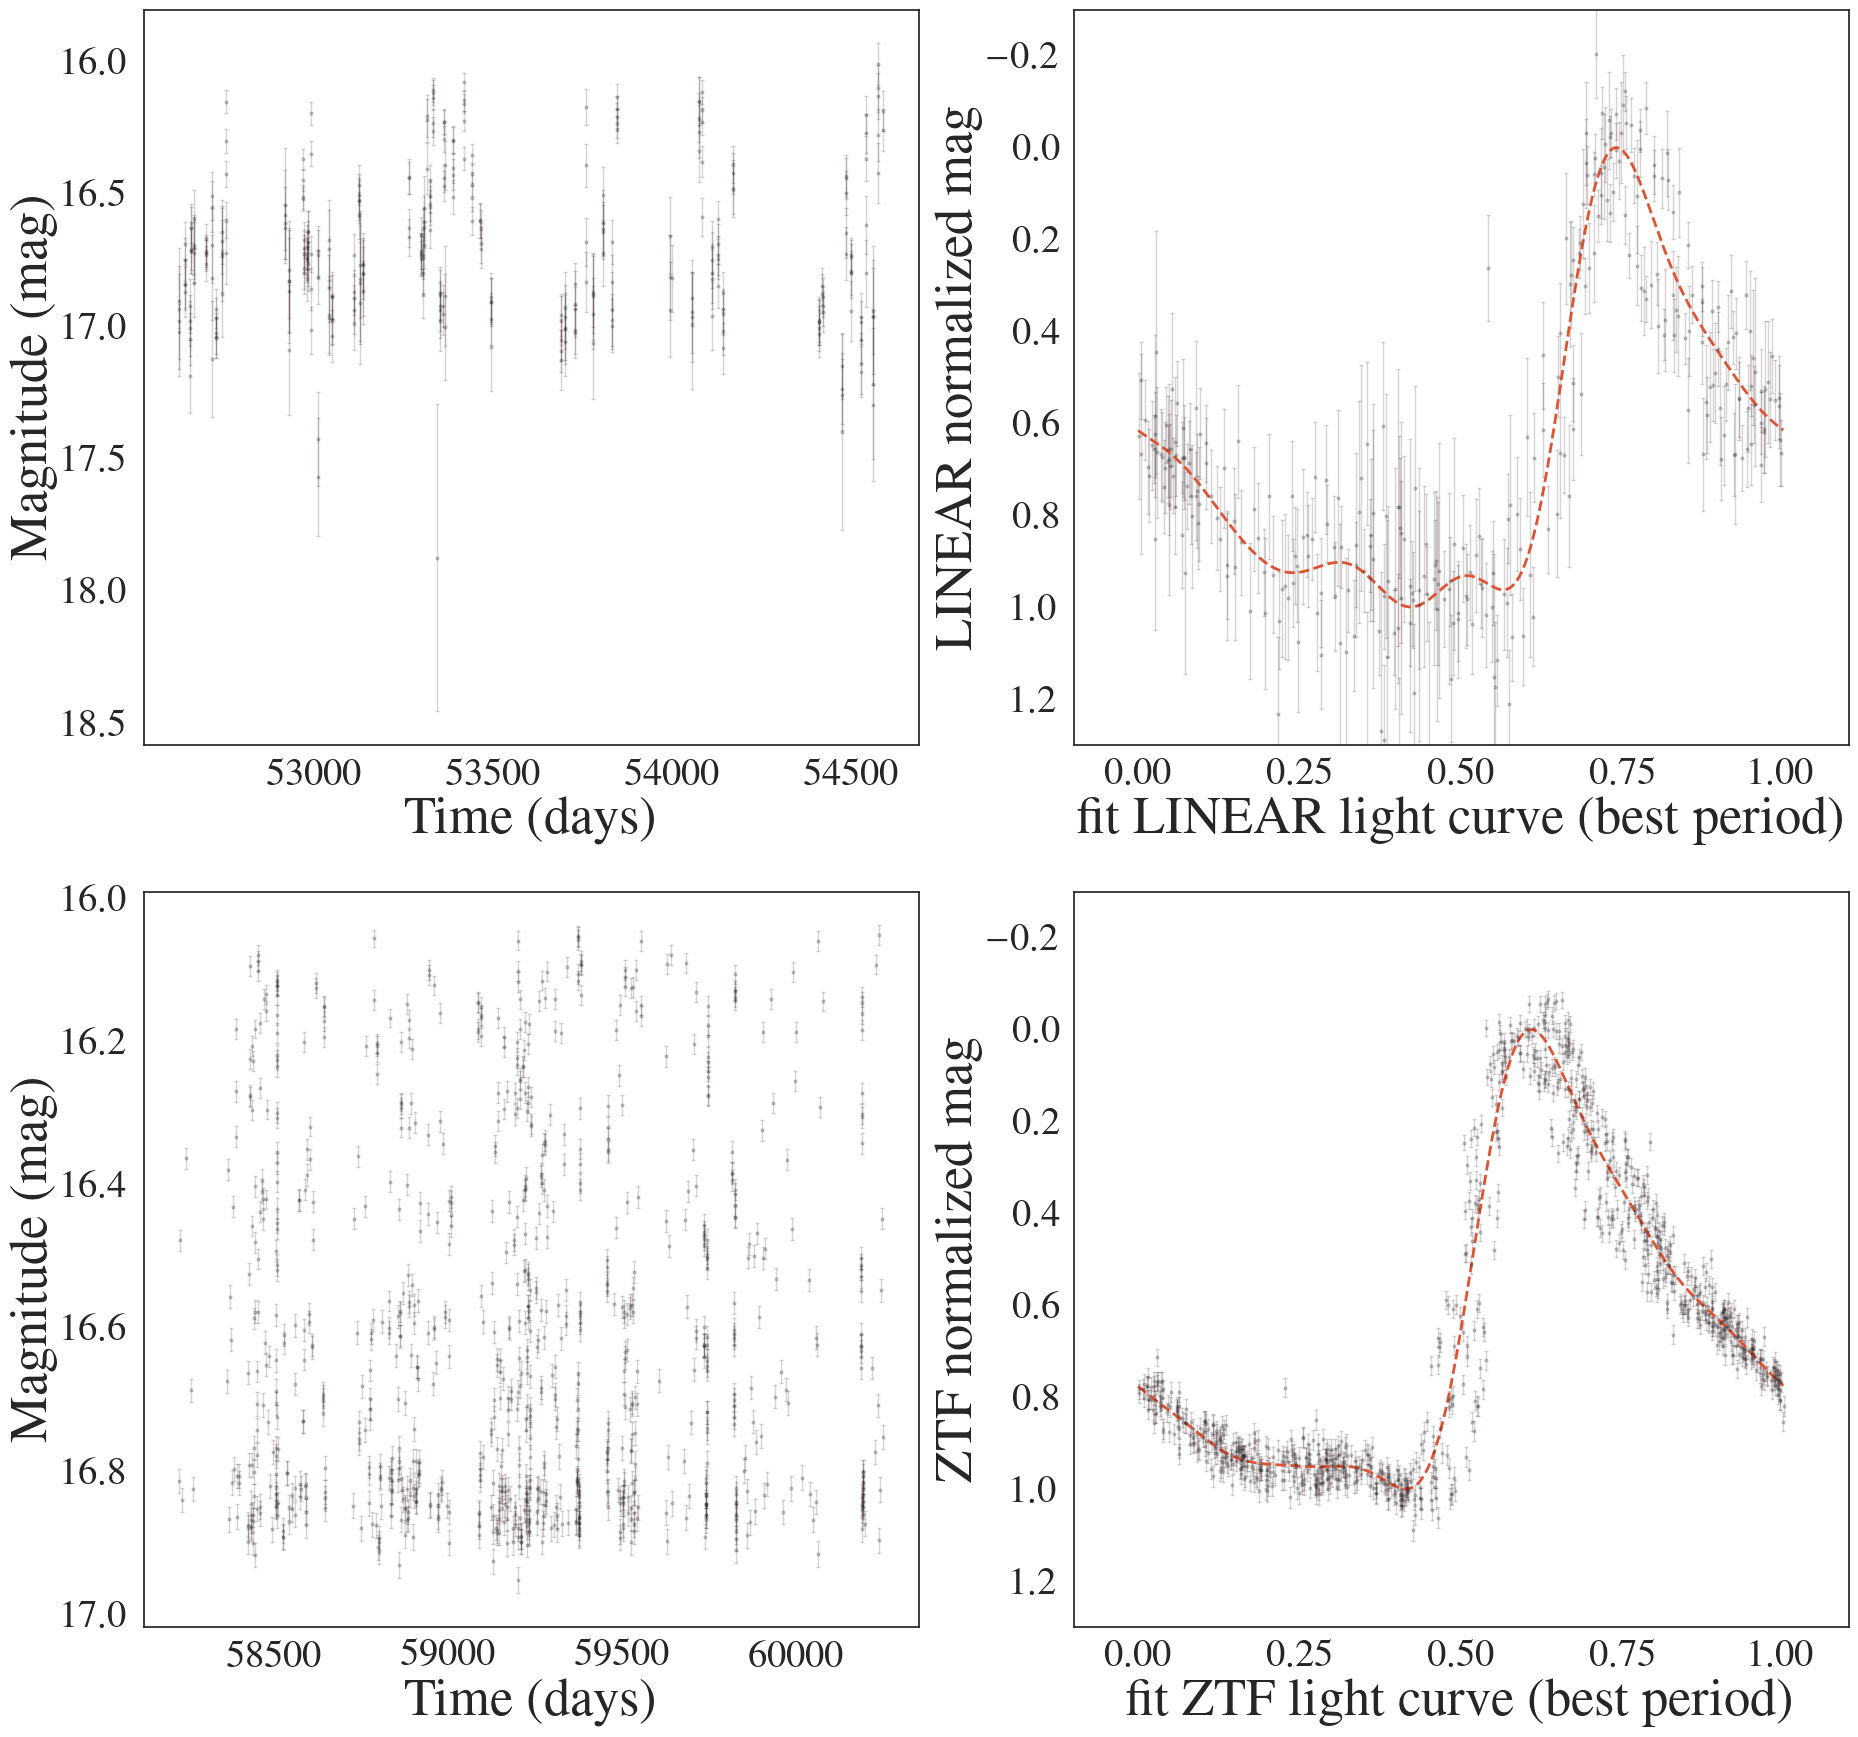

In [18]:
# selecting the data
total_num = len(Lids)
Lid = Lids[ID]
lc_data_ID = dataL.get_light_curve(Lid)
time, mag, magerr = lc_data_ID.T
tZ, mZ, meZ = ztf_data[ID][1], ztf_data[ID][2], ztf_data[ID][3]
for n, j in enumerate(fits):
    if j[0]==Lid:
        break

L1 = fits[n][1][0]
L2 = fits[n][1][2]

# setting up the plot
fig = plt.figure(figsize=(22, 21))
fig.set_facecolor('white')

# LINEAR full observation time
#--------
ax = fig.add_subplot(221)
ax.errorbar(time, mag, magerr, fmt='.k', ecolor=black1,lw=1, ms=4, capsize=1.5,alpha=0.2)
ax.set_xlabel('Time (days)',fontproperties=font, fontsize=38)
ax.set_ylabel('Magnitude (mag)', fontproperties=font, fontsize=38)
#fig.subtitle('LINEAR object {0}'.format(Lid), fontproperties=font, fontsize=38)
ax.invert_yaxis()
ax.tick_params(labelsize=28)

# LINEAR phased light curve
# -----
ax = fig.add_subplot(222)

ax.set_xlabel('fit LINEAR light curve (best period)', fontproperties=font, fontsize=38)
ax.set_ylabel('LINEAR normalized mag', fontproperties=font, fontsize=38)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L1['dataPhasedTime'], L1['dataTemplate'], L1['dataTemplateErr'])
ax.errorbar(xx, yy, zz, fmt='.k', ecolor=black1, lw=1, ms=4, capsize=1.5, alpha=0.2)
# fit for Plinear
ax.plot(L1['modelPhaseGrid'], L1['modTemplate'], or3, markeredgecolor=or3, lw=2, fillstyle='top', linestyle='dashed')
ax.tick_params(labelsize=28)

# ZTF full observation time
#--------
ax = fig.add_subplot(223)

ax.errorbar(tZ, mZ, meZ, fmt='.k', ecolor=black1,lw=1, ms=4, capsize=1.5,alpha=0.2)
ax.set_xlabel('Time (days)',fontproperties=font, fontsize=38)
ax.set_ylabel('Magnitude (mag)', fontproperties=font, fontsize=38)
ax.invert_yaxis()
ax.tick_params(labelsize=28)

# ZTF phased light curve
# -----
ax = fig.add_subplot(224)

ax.set_xlabel('fit ZTF light curve (best period)', fontproperties=font, fontsize=38)
ax.set_ylabel('ZTF normalized mag', fontproperties=font, fontsize=38)
ax.set_xlim(-0.1, 1.1)
ax.set_ylim(1.3, -0.3)
# data
xx, yy, zz = sort3arr(L2['dataPhasedTime'], L2['dataTemplate'], L2['dataTemplateErr'])
ax.errorbar(xx, yy, zz, fmt='.k', ecolor=black1, lw=1, ms=4, capsize=1.5, alpha=0.2)
# fit for Plinear
ax.plot(L2['modelPhaseGrid'], L2['modTemplate'], or3, markeredgecolor=or3, lw=2, fillstyle='top', linestyle='dashed')
#plt.tight_layout()
ax.tick_params(labelsize=28)

plt.savefig('../img_rsc/lc_pair.png', dpi=400)

## Chi2 graph

In [6]:
lc_master.head()

,LINEAR ID,Plinear,Pztf,N_L,N_Z,L_chi2r,Z_chi2r,L_chi2,Z_chi2,Lampl,Zampl,Ampl_diff,BpeakL,BpeakZ,BperiodL,BperiodZ,Periodogram_f,B_score,Blazhko_f
0,29848,0.557020,0.557040,301,43,1.4,3.5,3.0,12.6,0.56,0.93,0.37,1.8328,1.7982,26.6205,333.3333,-,6,1
1,50402,0.643303,0.643294,284,586,0.7,1.1,0.6,1.8,0.48,0.69,0.21,1.6223,1.5918,14.7351,26.8420,-,0,-1
2,62892,0.530776,0.530785,276,771,0.9,3.2,1.1,19.8,0.62,0.64,0.02,1.9519,1.9433,14.7319,16.8634,-,5,1
3,91437,0.674733,0.674737,177,564,1.3,2.0,2.8,5.6,0.87,1.21,0.34,1.5498,1.4849,14.7580,355.8719,-,0,-1
4,95250,0.313870,0.313876,222,916,0.8,1.4,0.8,3.0,0.48,0.46,0.02,3.2565,3.1889,14.1844,342.4658,-,0,-1


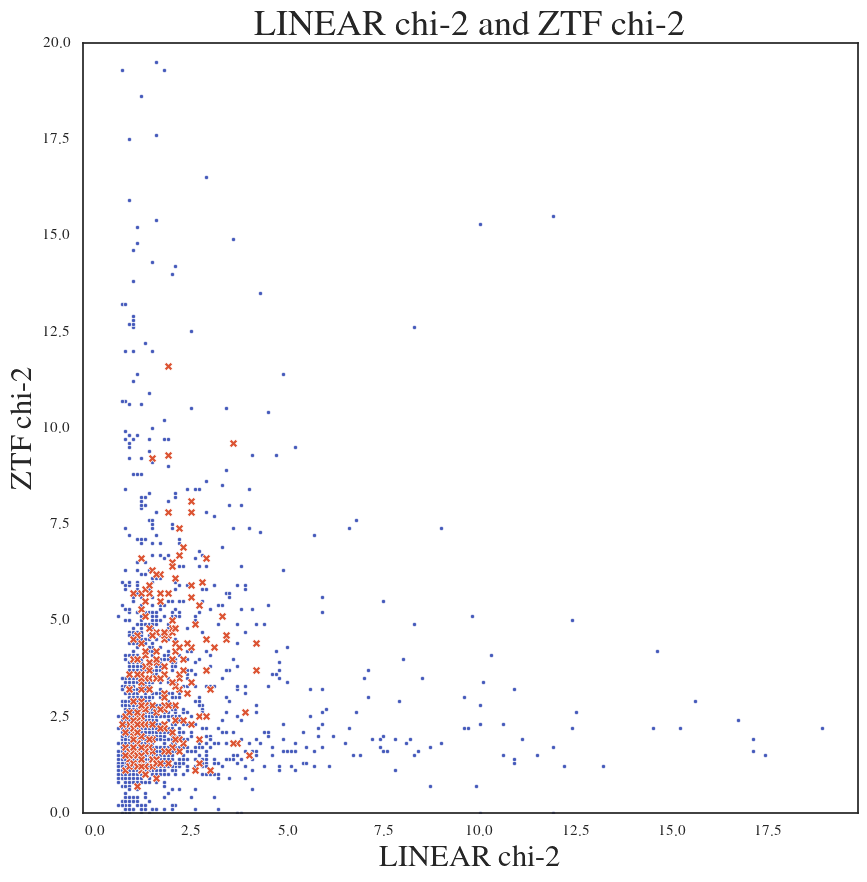

In [9]:
# scatterplot of periods
# ------
plt.figure(figsize=(10,10))

sns.scatterplot(data=lc_master, x='L_chi2r', y='Z_chi2r', marker='.', color=b1)
sns.scatterplot(data=BE_STARS, x='L_chi2dofR', y='Zchi2dofR', marker='X', color=or3)
#plt.xlim([0, 1.1])
plt.ylim([0, 20])
plt.title('LINEAR chi-2 and ZTF chi-2', fontproperties=font,fontsize=26)
plt.xlabel('LINEAR chi-2', fontproperties=font, fontsize=22)
plt.ylabel('ZTF chi-2', fontproperties=font,fontsize=22)
plt.savefig('../img_rsc/chi_scatter_expanded.png', dpi=150)
plt.show()

# UpSet Plot

In [14]:
blazhko_can_stat = pd.read_csv("../outputs/blazhko_stats"+end+"_expanded.csv")

print(be_cand.shape)
be_cand.head(10)

(618, 35)


,LINEAR id,Plinear,Pztf,Pmean,Pratio,NdataLINEAR,L_chi2dof,L_chi2dofR,Lmean_chi2dof,Lmean_chi2dofR,...,BlazhkoPeakZ,BlazhkoPeriodZ,BpowerRatioZ,BsignificanceZ,Ampl_diff,dP,IndicatorType,ChiType,BE_score,period_vs_amp
0,29848,0.557020,0.557040,0.557030,1.000036,301,3.0,1.4,3.3,1.6,...,1.7982,333.3333,0.2573,10.0729,0.37,0.00004,NaN,Z,6.0,period
1,158779,0.609207,0.609189,0.609198,0.999970,293,3.7,1.6,4.3,1.6,...,1.6444,350.2627,0.0123,16.5371,0.21,0.00003,NaN,Z,6.0,period
2,263541,0.558218,0.558221,0.558220,1.000005,270,15.8,2.9,16.2,3.0,...,1.8025,89.9685,0.0021,7.5968,0.18,0.00001,NaN,Z,7.0,amp
3,514883,0.557723,0.557737,0.557730,1.000025,289,5.3,1.7,5.4,1.6,...,1.7958,357.1429,0.0149,17.9476,0.17,0.00003,NaN,Z,7.0,period
4,523832,0.372376,0.372384,0.372380,1.000021,251,1.8,1.2,1.9,1.3,...,2.7122,37.3413,0.1528,6.3617,0.17,0.00002,Z,NaN,NaN,NaN
5,737951,0.357023,0.357023,0.357023,1.000000,273,6.0,2.2,6.0,2.2,...,2.8039,332.2259,0.0020,13.7006,0.09,0.00000,NaN,Z,6.0,amp
6,803829,0.595281,0.595286,0.595284,1.000008,270,8.7,2.3,9.7,2.7,...,1.6828,335.5705,0.0082,17.8498,0.43,0.00001,NaN,Z,10.0,amp
7,810169,0.465185,0.465212,0.465198,1.000058,289,6.0,2.1,8.2,2.3,...,2.2230,13.6082,0.0077,16.1490,0.02,0.00006,NaN,Z,12.0,period
8,880588,0.600138,0.600134,0.600136,0.999993,295,3.2,1.2,3.3,1.2,...,1.6736,136.4256,0.0109,14.7971,0.07,0.00001,L,NaN,NaN,NaN
9,924301,0.507503,0.507440,0.507472,0.999876,418,13.8,1.9,35.3,3.8,...,1.9763,178.4121,0.0219,18.8612,0.08,0.00012,NaN,Z,10.0,period


In [15]:
print(blazhko_can_stat.shape)
blazhko_can_stat.head(10)

(2857, 6)


,LINEAR chi2,ZTF chi2,LINEAR periodogram,ZTF periodogram,Amplitude,Period difference
0,0,0,0,0,0,0
1,0,0,0,0,1,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0
5,0,0,0,0,0,0
6,0,0,0,0,0,0
7,0,0,0,0,0,0
8,0,1,0,0,0,1
9,0,0,0,0,0,0


In [16]:
grouped = blazhko_can_stat.groupby(['LINEAR chi2', 'ZTF chi2', 'LINEAR periodogram', 'ZTF periodogram', 'Amplitude', 'Period difference']).size().reset_index(name='counts')
grouped

,LINEAR chi2,ZTF chi2,LINEAR periodogram,ZTF periodogram,Amplitude,Period difference,counts
0,0,0,0,0,0,0,2513
1,0,0,0,0,1,0,48
2,0,0,0,0,1,1,1
3,0,0,0,1,0,0,19
4,0,0,1,0,0,0,30
5,0,0,1,1,0,0,1
6,0,1,0,0,0,0,75
7,0,1,0,0,0,1,5
8,0,1,0,0,1,0,80
9,0,1,0,0,1,1,5


<Figure size 1500x1000 with 0 Axes>

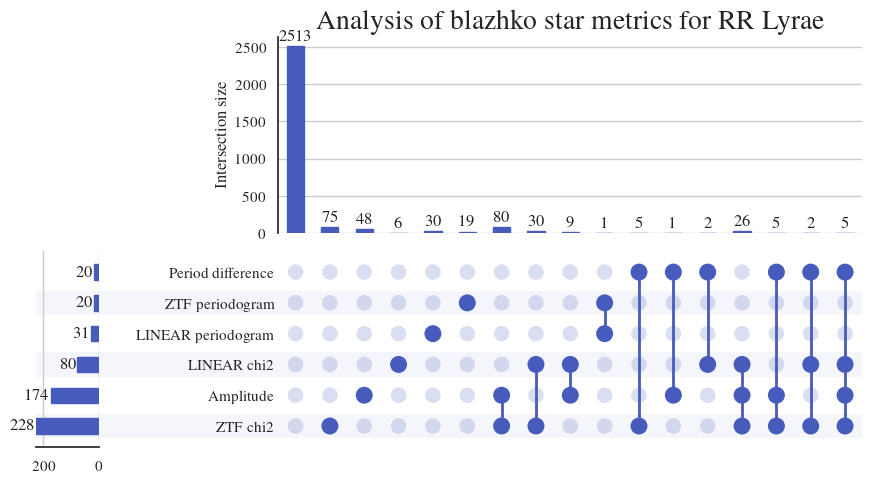

In [17]:
from upsetplot import UpSet

# Convert grouped DataFrame to a format for UpSet plot
binary_columns = ['LINEAR chi2', 'ZTF chi2', 'LINEAR periodogram', 'ZTF periodogram', 'Amplitude', 'Period difference']
upset_data = grouped.set_index(binary_columns)['counts']

# Create UpSet plot
plt.figure(figsize=(15, 10))
upset = UpSet(upset_data, subset_size='sum', sort_by='degree', facecolor=b1, other_dots_color=0.2, show_counts=True)
upset.plot()
plt.title("Analysis of blazhko star metrics for RR Lyrae", fontsize=20)
#plt.tick_params(labelsize=28)
plt.savefig('../img_rsc/stats_categories_expanded.png', dpi=500)
plt.show()


In [22]:
len(BE_STARS[BE_STARS['IndicatorType'] == 'Z'])

11

In [23]:
len(BE_STARS[BE_STARS['IndicatorType'] == 'L'])

13

In [27]:
219 - (11+13)

195